# Some EDA with Homicide rates

By Andy Wheeler

For background [see my blogpost](https://andrewpwheeler.com/2023/07/09/some-notes-on-synthetic-control-and-hogan-kaplan/).

Note to fully replicate, you need to download the data from [Kaplan's replication materials](https://www.openicpsr.org/openicpsr/project/176021/version/V2/view), the file `srs_top_cities.dta` is too big to upload to github.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'figure.dpi': 100}

matplotlib.rcParams.update(andy_theme)

# load in data, this is via Kaplan's replication files
# UCR data
crimes = pd.read_stata('srs_top_cities.dta')

# Only keep agencies in Hogan top 100 sample
crimes = crimes[crimes['type'] != ''].copy()

# only keep full reporting
crimes = crimes[crimes['number_of_months_missing'] == 0].copy()

# Only keep agencies with full 20 years of data
# I am keeping this in, as many of these cities have weird data values
# Birmingham 2019, Raleigh 2019, Winston-Salem 2019
# easier just to eliminate
city_20 = crimes['city'].value_counts().reset_index().sort_values('city')

# To show cities not in the 20 list
city_20[city_20.city != 20]

index  city
99                      Louisville    16
98                         Raleigh    16
96                      Birmingham    18
95                  Chesapeake, VA    18
94                        Honolulu    18
93                   Winston-Salem    18
97                 North Las Vegas    18
86          Oakland/Alameda County    19
88      Greensboro/Guilford County    19
87  Lincoln, Neb./Lancaster County    19
90                          Newark    19
91       Portland/Multnomah County    19
92                     New Orleans    19
89                          Durham    19

In [2]:
# Only keeping cities with full reporting in the 20 years
city_20 = city_20['index'][city_20.city == 20].tolist()
crimes = crimes[crimes['city'].isin(city_20)].copy()

# Prep final data
# Replace the Philly numbers with Hogans, 2010-2019
# only really makes a difference for 2019
philly_recent = [306,
                 326,
                 331,
                 246,
                 248,
                 280,
                 277,
                 315,
                 353,
                 356]

Philly = (crimes['city'] == 'Philadelphia') & (crimes['year'] >= 2010)

crimes['hom'] = crimes[['actual_murder', 'actual_manslaughter']].sum(axis=1)
crimes.loc[Philly,'hom'] = philly_recent
crimes['hom_rate'] = (crimes['hom']/crimes['population'])*100000
crimes['Philly'] = 1*(crimes['city'] == 'Philadelphia')

keep_fields = ['city','ori','year','population',
               'hom','hom_rate','type','Philly']

crimes = crimes[keep_fields].sort_values(by=['city','year'],ignore_index=True)

int_fields = ['year','population','hom','Philly']
crimes[int_fields] = crimes[int_fields].astype(int)

#crimes['year'] = crimes['year'].astype(int)
crimes.sort_values(by=['Philly','city','year'], inplace=True, ignore_index=True)

# Check out this file in Github page
crimes.to_csv('TopCitiesHomRate.csv',index=False)

crimes

city      ori  year  population  hom   hom_rate         type  \
0      Albuquerque  NM00101  2000      448607   38   8.470666  Progressive   
1      Albuquerque  NM00101  2001      451098   36   7.980528  Progressive   
2      Albuquerque  NM00101  2002      457488   54  11.803588  Progressive   
3      Albuquerque  NM00101  2003      468764   52  11.093002  Progressive   
4      Albuquerque  NM00101  2004      479074   44   9.184385  Progressive   
...            ...      ...   ...         ...  ...        ...          ...   
1715  Philadelphia  PAPEP00  2015     1567810  248  15.818243  Progressive   
1716  Philadelphia  PAPEP00  2016     1570826  246  15.660551  Progressive   
1717  Philadelphia  PAPEP00  2017     1575595  331  21.007937  Progressive   
1718  Philadelphia  PAPEP00  2018     1586916  326  20.542990  Progressive   
1719  Philadelphia  PAPEP00  2019     1589014  306  19.257225  Progressive   

      Philly  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
1715       1  
1716       1  
1717       1  
1718       1  
1719       1  

[1720 rows x 8 columns]

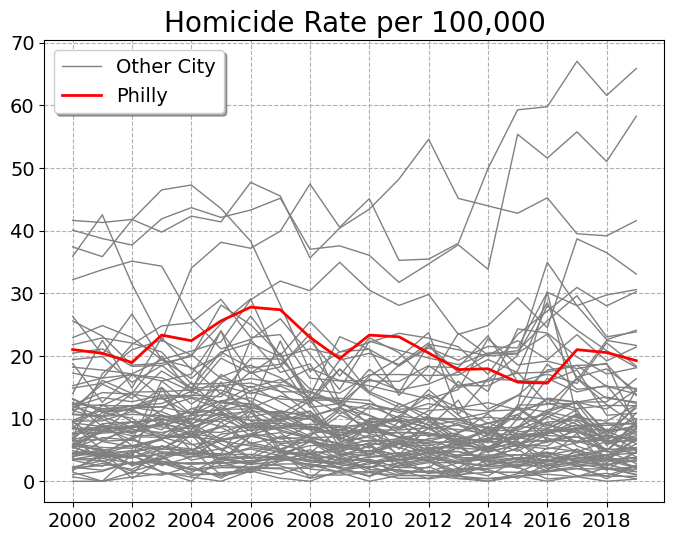

In [3]:
# Homicide rates, all cities
year_lab = np.arange(2000,2020,2)
un_cities = list(pd.unique(crimes['city']))

fig, ax = plt.subplots(figsize=(8,6))

for c in un_cities:
    sd = crimes[crimes['city'] == c]
    lab = 0
    if c == 'Philadelphia':
        ax.plot(sd['year'], sd['hom_rate'], label='Philly', color='red', linewidth=2)
    elif c == un_cities[0]:
        ax.plot(sd['year'], sd['hom_rate'], label='Other City', color='grey', linewidth=1)
    else:
        ax.plot(sd['year'], sd['hom_rate'], color='grey', linewidth=1)

ax.set_axisbelow(True)
ax.set_xticks(year_lab)
ax.set_title('Homicide Rate per 100,000')
ax.legend(loc='upper left')
plt.show()

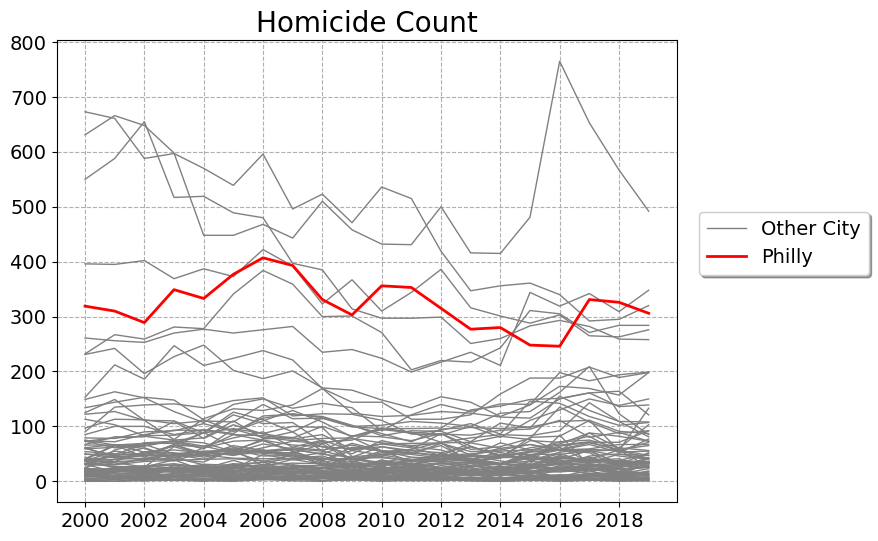

In [4]:
# Homicide Counts

fig, ax = plt.subplots(figsize=(8,6))

for c in un_cities:
    sd = crimes[crimes['city'] == c]
    lab = 0
    if c == 'Philadelphia':
        ax.plot(sd['year'], sd['hom'], label='Philly', color='red', linewidth=2)
    elif c == un_cities[0]:
        ax.plot(sd['year'], sd['hom'], label='Other City', color='grey', linewidth=1)
    else:
        ax.plot(sd['year'], sd['hom'], color='grey', linewidth=1)

ax.set_axisbelow(True)
ax.set_xticks(year_lab)
ax.set_title('Homicide Count')
ax.legend(bbox_to_anchor=(1.02,0.65))
plt.show()

<ipython-input-5-4bdfb2fdd492>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ct = crimes.groupby(['Philly','type','year'], as_index=False)['hom','population'].sum()


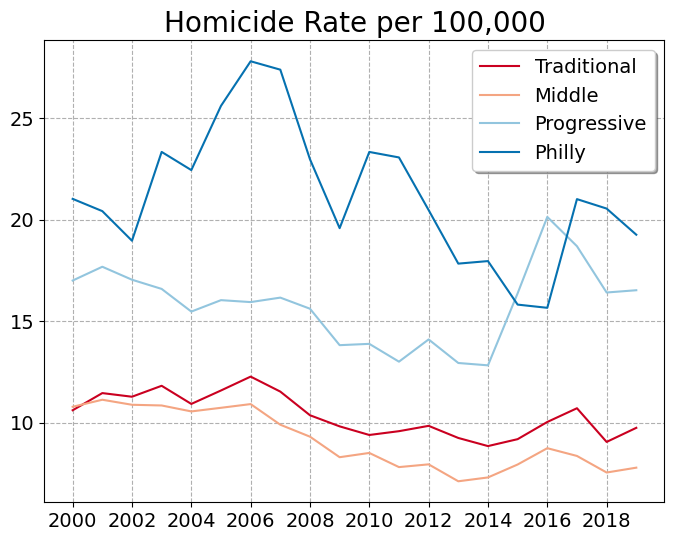

In [5]:
# Weighted aggregate rate, Philly and prosecutor type
ct = crimes.groupby(['Philly','type','year'], as_index=False)['hom','population'].sum()
ct['hom_rate'] = (ct['hom']/ct['population'])*100000

rep_dict = {'0Traditional': 'Traditional',
            '0Middle': 'Middle',
            '0Progressive': 'Progressive',
            '1Progressive': 'Philly'}

ct['group'] = (ct['Philly'].astype(str) + ct['type']).replace(rep_dict)

# Now lets do for each a line
colors = ['#ca0020',
          '#f4a582',
          '#92c5de',
          '#0571b0']

fig, ax = plt.subplots(figsize=(8,6))

for g,c in zip(rep_dict.values(),colors):
    sd = ct[ct['group'] == g]
    ax.plot(sd['year'], sd['hom_rate'], label=g, color=c)

ax.set_axisbelow(True)
ax.set_xticks(year_lab)
ax.set_title('Homicide Rate per 100,000')
ax.legend(loc='upper right')
plt.show()

Note that the big "Progressive" increase in this data is likely attributable to mostly Chicago!

In [6]:
crimes[crimes['city'] == 'Chicago/Cook County']

city      ori  year  population  hom   hom_rate  \
300  Chicago/Cook County  ILCPD00  2000     2896016  631  21.788554   
301  Chicago/Cook County  ILCPD00  2001     2910709  666  22.881023   
302  Chicago/Cook County  ILCPD00  2002     2938299  648  22.053576   
303  Chicago/Cook County  ILCPD00  2003     2898374  598  20.632258   
304  Chicago/Cook County  ILCPD00  2004     2882746  448  15.540738   
305  Chicago/Cook County  ILCPD00  2005     2873441  448  15.591063   
306  Chicago/Cook County  ILCPD00  2006     2857796  468  16.376256   
307  Chicago/Cook County  ILCPD00  2007     2824434  443  15.684558   
308  Chicago/Cook County  ILCPD00  2008     2829304  510  18.025635   
309  Chicago/Cook County  ILCPD00  2009     2848431  458  16.079027   
310  Chicago/Cook County  ILCPD00  2010     2695598  432  16.026129   
311  Chicago/Cook County  ILCPD00  2011     2703713  431  15.941041   
312  Chicago/Cook County  ILCPD00  2012     2708382  500  18.461207   
313  Chicago/Cook County  ILCPD00  2013     2720554  416  15.291003   
314  Chicago/Cook County  ILCPD00  2014     2724121  415  15.234272   
315  Chicago/Cook County  ILCPD00  2015     2728695  481  17.627474   
316  Chicago/Cook County  ILCPD00  2016     2725153  765  28.071818   
317  Chicago/Cook County  ILCPD00  2017     2706171  653  24.130035   
318  Chicago/Cook County  ILCPD00  2018     2719151  567  20.852097   
319  Chicago/Cook County  ILCPD00  2019     2707064  492  18.174672   

            type  Philly  
300  Progressive       0  
301  Progressive       0  
302  Progressive       0  
303  Progressive       0  
304  Progressive       0  
305  Progressive       0  
306  Progressive       0  
307  Progressive       0  
308  Progressive       0  
309  Progressive       0  
310  Progressive       0  
311  Progressive       0  
312  Progressive       0  
313  Progressive       0  
314  Progressive       0  
315  Progressive       0  
316  Progressive       0  
317  Progressive       0  
318  Progressive       0  
319  Progressive       0